In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL
from PIL import Image, ImageOps
import cv2
from sklearn.utils import class_weight, shuffle
from keras.losses import binary_crossentropy
from keras.applications.resnet50 import preprocess_input
import keras.backend as K
import tensorflow as tf
from sklearn.metrics import f1_score, fbeta_score
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/opt/anaconda/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda/anaconda3/lib/python3.7/site-packages/t

# Data Split


In [12]:
df_2019 = pd.read_csv('../data/aptos-data-split/df_2019.csv')
df_2015 = pd.read_csv('../data/aptos-data-split/df_2015_raw.csv')

Distribution of Whole 2019 Data

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64
0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64


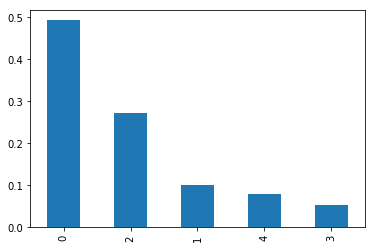

In [10]:
print("Distribution of Whole 2019 Data\n")
print(df_2019["diagnosis"].value_counts())
print(df_2019["diagnosis"].value_counts(True))
df_2019["diagnosis"].value_counts(True).plot.bar()

Distribution of Whole 2015 Data

0    25810
2     5292
1     2443
3      873
4      708
Name: diagnosis, dtype: int64


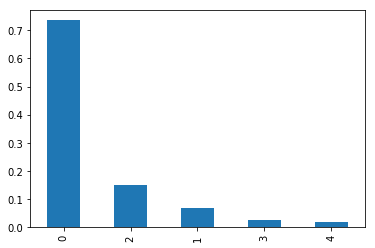

In [14]:
print("Distribution of Whole 2015 Data\n")
print(df_2015["diagnosis"].value_counts())
df_2015["diagnosis"].value_counts(True).plot.bar()

## Hold-out

Distribution of 2019 Train/Valid

is_valid  diagnosis
False     0            0.491294
          2            0.270741
          1            0.103107
          4            0.079208
          3            0.055650
True      0            0.499318
          2            0.281037
          1            0.092769
          4            0.085948
          3            0.040928
Name: diagnosis, dtype: float64
is_valid  diagnosis
False     0            1439
          2             793
          1             302
          4             232
          3             163
True      0             366
          2             206
          1              68
          4              63
          3              30
Name: diagnosis, dtype: int64


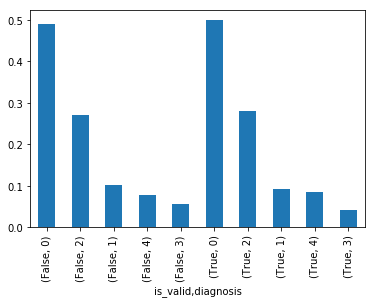

In [15]:
print("Distribution of 2019 Train/Valid\n")
print(df_2019.groupby("is_valid")["diagnosis"].value_counts("True"))
print(df_2019.groupby("is_valid")["diagnosis"].value_counts())
df_2019.groupby("is_valid")["diagnosis"].value_counts("True").plot("bar")

Distribution of 2015 Train/Valid

is_valid  diagnosis
False     0            0.734947
          2            0.151246
          1            0.069929
          3            0.023950
          4            0.019929
True      0            0.734130
          2            0.148306
          1            0.068033
          3            0.028466
          4            0.021065
Name: diagnosis, dtype: float64


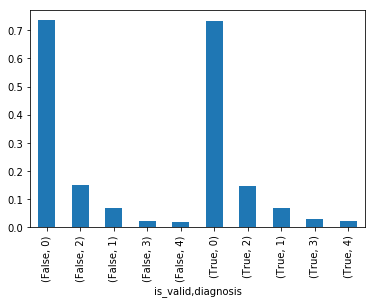

In [16]:
print("Distribution of 2015 Train/Valid\n")
print(df_2015.groupby("is_valid")["diagnosis"].value_counts("True"))
df_2015.groupby("is_valid")["diagnosis"].value_counts("True").plot("bar")

## Cross Validation

In [17]:
df_2019_cv = pd.read_csv('../data/aptos-data-split/df_2019_cv.csv')

Distribution of 2019 Fold 1 Train/Valid

is_valid1  diagnosis
False      0            0.493001
           2            0.272789
           1            0.101058
           4            0.080574
           3            0.052578
True       0            0.492497
           2            0.272851
           1            0.100955
           4            0.080491
           3            0.053206
Name: diagnosis, dtype: float64


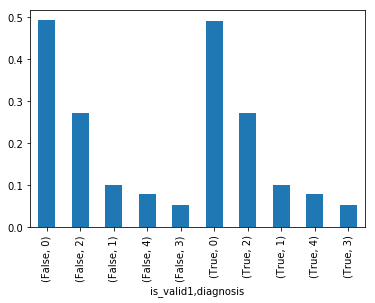

Distribution of 2019 Fold 2 Train/Valid

is_valid2  diagnosis
False      0            0.493001
           2            0.272789
           1            0.101058
           4            0.080574
           3            0.052578
True       0            0.492497
           2            0.272851
           1            0.100955
           4            0.080491
           3            0.053206
Name: diagnosis, dtype: float64


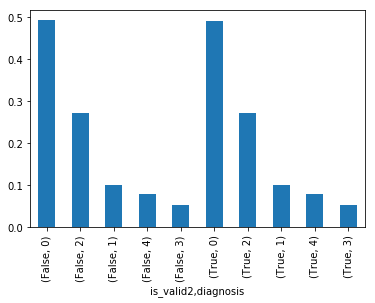

Distribution of 2019 Fold 3 Train/Valid

is_valid3  diagnosis
False      0            0.493001
           2            0.272789
           1            0.101058
           4            0.080574
           3            0.052578
True       0            0.492497
           2            0.272851
           1            0.100955
           4            0.080491
           3            0.053206
Name: diagnosis, dtype: float64


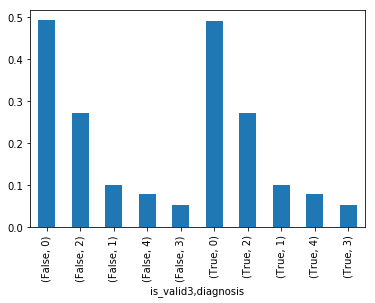

Distribution of 2019 Fold 4 Train/Valid

is_valid4  diagnosis
False      0            0.492833
           2            0.272696
           1            0.101024
           4            0.080546
           3            0.052901
True       0            0.493169
           2            0.273224
           1            0.101093
           4            0.080601
           3            0.051913
Name: diagnosis, dtype: float64


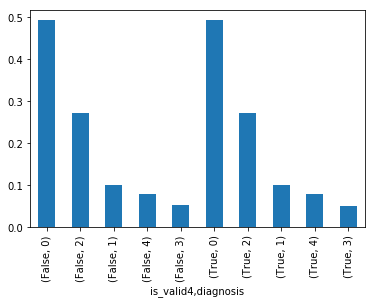

Distribution of 2019 Fold 5 Train/Valid

is_valid5  diagnosis
False      0            0.492665
           2            0.272944
           1            0.100989
           4            0.080519
           3            0.052883
True       0            0.493844
           2            0.272230
           1            0.101231
           4            0.080711
           3            0.051984
Name: diagnosis, dtype: float64


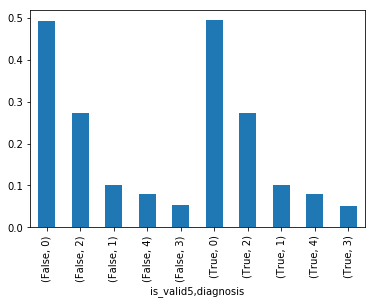

In [18]:
for i in range(1, 6):
    print("Distribution of 2019 Fold {} Train/Valid\n".format(i))
    print(df_2019_cv.groupby("is_valid"+str(i))["diagnosis"].value_counts("True"))
    df_2019_cv.groupby("is_valid"+str(i))["diagnosis"].value_counts("True").plot("bar")
    plt.show()

# Image Size

In [30]:
def get_img_short_size(path):
    image = cv2.imread(path)
    w, h, c = image.shape
    
    return w if w < h else h

In [29]:
df_2019["short_size"] = df_2019["path"].apply(get_img_short_size)
df_2019["short_size"].describe()

count    3662.000000
mean     1526.830147
std       542.663120
min       358.000000
25%      1050.000000
50%      1536.000000
75%      1958.000000
max      2848.000000
Name: short_size, dtype: float64

In [31]:
df_2015["short_size"] = df_2015["path"].apply(get_img_short_size)
df_2015["short_size"].describe()

count    35126.000000
mean       702.352929
std         39.767900
min        289.000000
25%        683.000000
50%        683.000000
75%        683.000000
max       1024.000000
Name: short_size, dtype: float64

# Preprocessing

In [20]:
WORKERS = 2
CHANNEL = 3

IMG_SIZE = 512
NUM_CLASSES = 5
SEED = 77
TRAIN_NUM = 1000 # use 1000 when you just want to explore new idea, use -1 for full train

In [21]:
df_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

x = df_train['id_code']
y = df_train['diagnosis']

x, y = shuffle(x, y, random_state=SEED)

(3112,) (3112,) (550,) (550,)


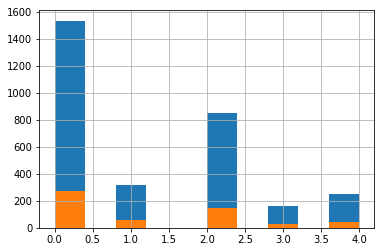

In [6]:


train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,
                                                      stratify=y, random_state=SEED)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()



## 2019 Train


CPU times: user 8.02 s, sys: 112 ms, total: 8.13 s
Wall time: 2.86 s


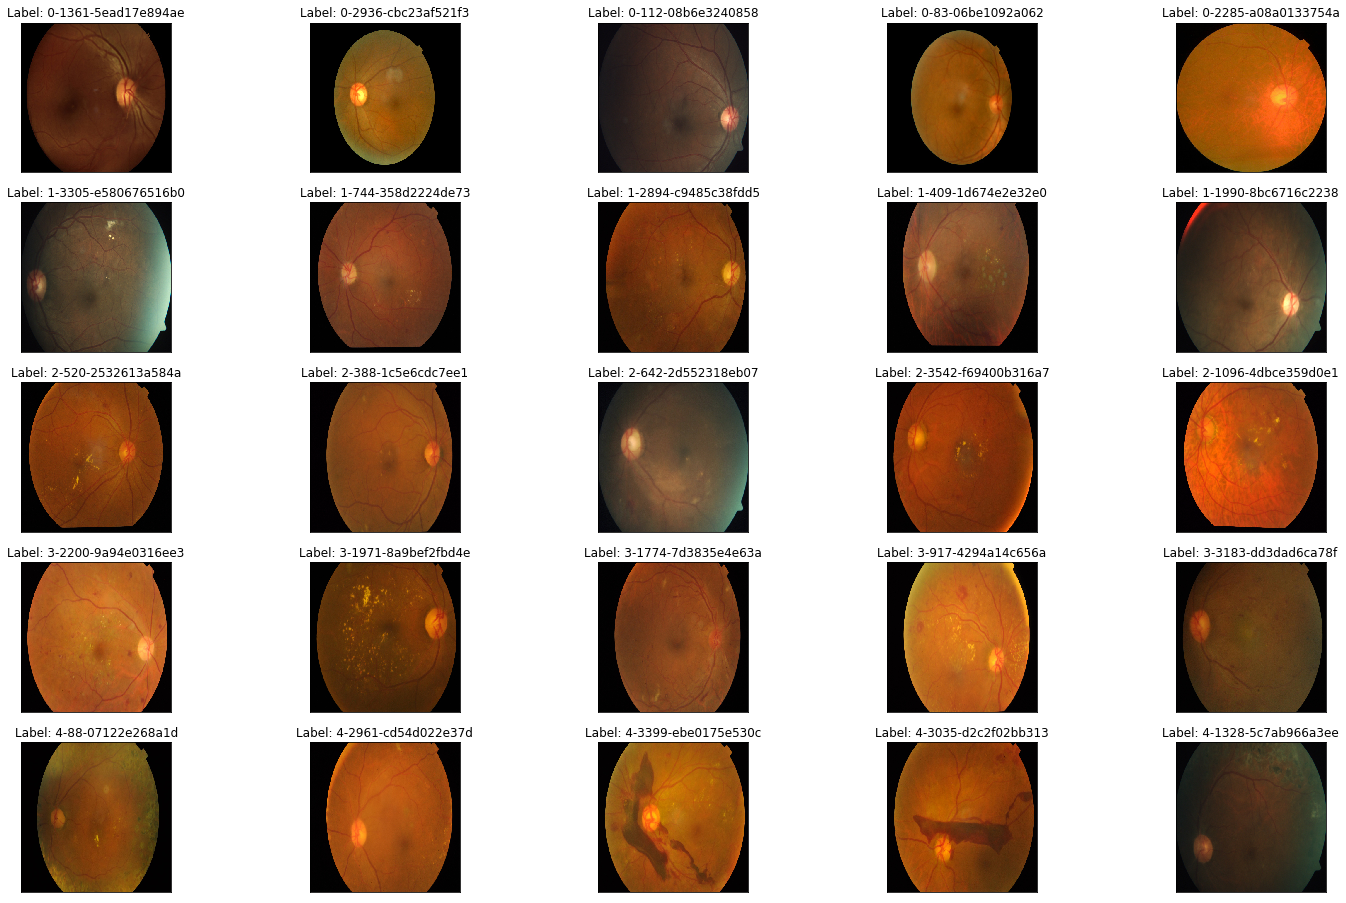

In [23]:
%%time
## Raw

fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

CPU times: user 3.17 s, sys: 64 ms, total: 3.23 s
Wall time: 502 ms


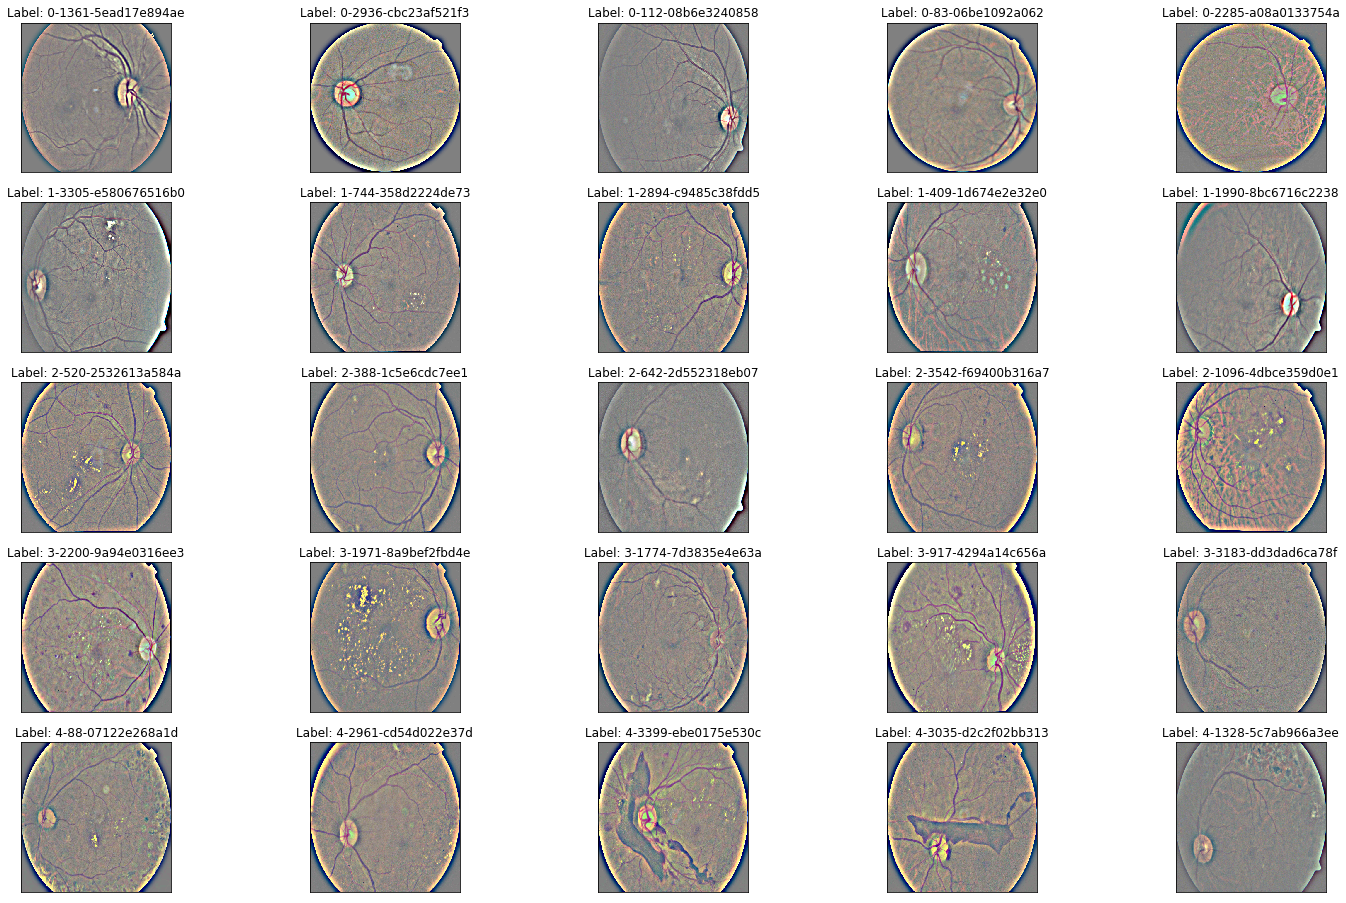

In [10]:
%%time
## Ben's Preprocessing sigmaX=10

fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for class_id in sorted(train_y.unique()):
    for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(5, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"../input/aptos2019-blindness-detection/train_images_ben_preprocessing_sigmaX10/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

## 2019 test

CPU times: user 4.46 s, sys: 0 ns, total: 4.46 s
Wall time: 754 ms


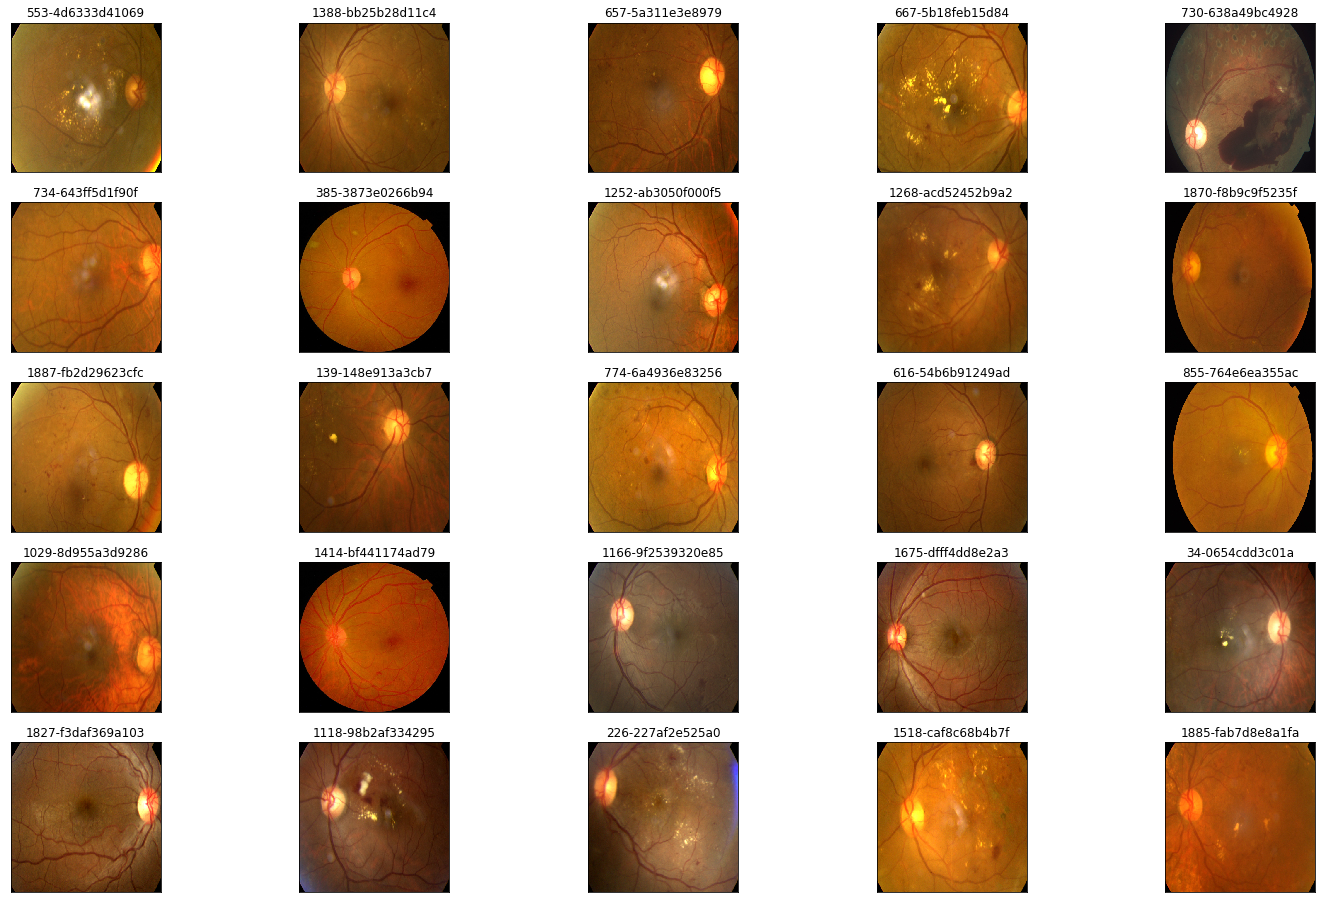

In [19]:
%%time
## Raw

fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, (idx, row) in enumerate(df_test.sample(25, random_state=SEED).iterrows()):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    path=f"../input/aptos2019-blindness-detection/test_images/{row['id_code']}.png"
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    plt.imshow(image)
    ax.set_title('%d-%s' % (idx, row['id_code']) )

CPU times: user 3.36 s, sys: 0 ns, total: 3.36 s
Wall time: 505 ms


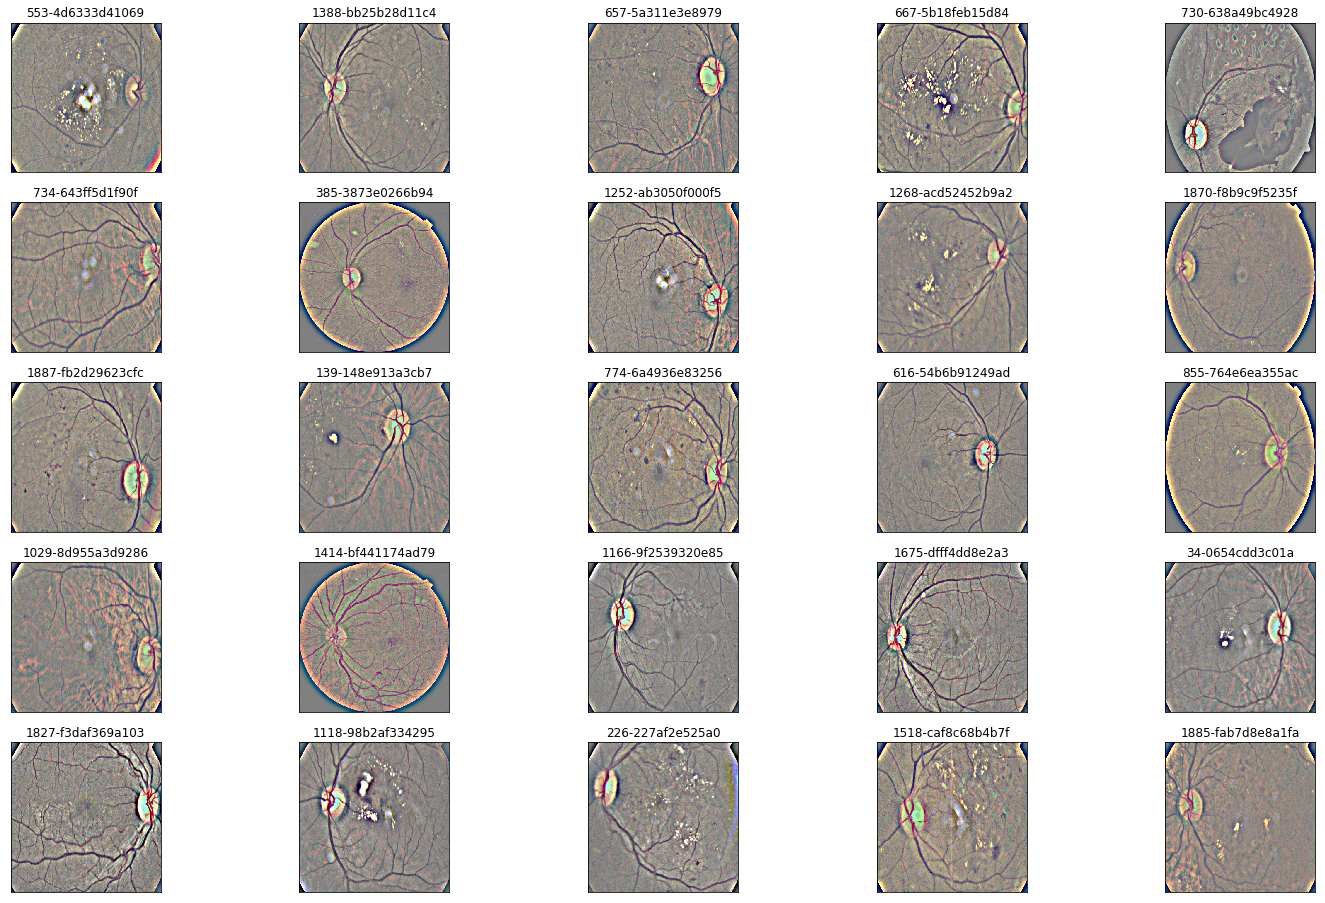

In [21]:
%%time
## Ben's Preprocessing sigmaX=10

fig = plt.figure(figsize=(25, 16))
# display 10 images from each class
for i, (idx, row) in enumerate(df_test.sample(25, random_state=SEED).iterrows()):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    path=f"../input/aptos2019-blindness-detection/test_images_ben_preprocessing_sigmaX10/{row['id_code']}.png"
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

    plt.imshow(image)
    ax.set_title('%d-%s' % (idx, row['id_code']) )